In [1]:
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, sosfiltfilt
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.widgets import Slider
from matplotlib.colors import TwoSlopeNorm
from scipy.interpolate import PchipInterpolator
import h5py
import cv2
import pandas as pd
from ipywidgets import HBox, VBox, IntSlider, Dropdown, Play, jslink, HTML
from IPython.display import display, clear_output
import os, time, re
import matplotlib.animation as animation
import imageio_ffmpeg
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
from scipy import interpolate

%matplotlib widget

In [2]:
def analytic_signal_fft_nd(x, axis=-1):
    """
    FFT-based Hilbert transform to get analytic signal along a given axis.
    Works for real x with arbitrary extra dims.
    Returns complex analytic signal with same shape.
    """
    x = np.asarray(x)
    n = x.shape[axis]
    X = np.fft.fft(x, n=n, axis=axis)
    h = np.zeros(n, dtype=float)
    if n % 2 == 0:
        h[0] = 1.0
        h[n//2] = 1.0
        h[1:n//2] = 2.0
    else:
        h[0] = 1.0
        h[1:(n+1)//2] = 2.0
    # reshape h to broadcast along 'axis'
    shape = [1]*x.ndim
    shape[axis] = n
    H = h.reshape(shape)
    Z = np.fft.ifft(X * H, axis=axis)
    return Z

def bandpass(movie, Fs, lo=1.0, hi=40.0, order=8):
    """
    Zero-phase bandpass of 'movie' along time axis (axis=2).
    """
    nyq = 0.5 * Fs
    sos = butter(order, [lo/nyq, hi/nyq], btype='bandpass', output='sos')
    return sosfiltfilt(sos, movie, axis=2)

def rewrap(phi):
    return (phi + np.pi) % (2*np.pi) - np.pi

def inst_freq_from_phase(phi, Fs):
    dphi = np.diff(phi)
    dphi = (dphi + np.pi) % (2*np.pi) - np.pi
    ifreq = (dphi / (2*np.pi)) * Fs
    return np.concatenate([ifreq, [np.nan]])

def repair_phase_with_pchip(phi_wrapped, bad_mask):
    phi = np.unwrap(phi_wrapped)
    phi_interp = phi.copy()
    phi_interp[bad_mask] = np.nan
    valid = ~np.isnan(phi_interp)
    if valid.sum() >= 2:
        xs = np.flatnonzero(valid); ys = phi_interp[valid]
        pchip = PchipInterpolator(xs, ys, extrapolate=False)
        phi_interp[~valid] = pchip(np.flatnonzero(~valid))
    return rewrap(phi_interp)

# --------- Analytic signal → amplitude & phase ----------
def phase_amp(movie_bp):
    """
    Compute analytic signal per pixel along time axis:
      z = x + i * Hilbert(x)
      amp = |z|
      phi = angle(z) in (-π, π]
    """
    z = analytic_signal_fft_nd(movie_bp, axis=2)
    amp = np.abs(z)
    phi = np.angle(z)
    return amp, phi

def smooth_phase_gaussian(z, amp=None, sigma_px=1.5, truncate=3.0, mode='reflect'):
    """
    Wrap-safe spatial smoothing of phase using the complex field.

    Parameters
    ----------
    z : complex array, shape (ny, nx, nt)
        Analytic signal. (From your FFT-Hilbert.)
    amp : float array, same shape as |z| (optional)
        If provided, we remove amplitude to avoid bias (recommended).
    sigma_px : float
        Spatial Gaussian sigma in pixels (gentle: 1.0–2.0 typical).
    truncate, mode : as in scipy.ndimage.gaussian_filter.

    Returns
    -------
    phi_s : float array (ny, nx, nt)
        Wrapped, gently smoothed phase.
    z_s   : complex array (ny, nx, nt)
        Smoothed *unit* complex field used to derive phi_s.
    """
    # Use unit phasors to avoid amplitude bias during smoothing
    if amp is None:
        amp = np.abs(z)
    eps = 1e-12
    z_unit = z / (amp + eps)

    # Smooth only in space (y,x), not time (t)
    z_s = gaussian_filter(z_unit, sigma=(sigma_px, sigma_px, 0.0),
                          truncate=truncate, mode=mode)

    # Convert back to wrapped phase
    phi_s = np.angle(z_s)
    return phi_s, z_s

def phase_gradient_from_complex(z_like, dx=1.0, dy=1.0):
    """
    Compute wrap-safe spatial phase gradients using complex products.

    Idea (Muller): the phase difference between neighboring samples equals
        Δφ = angle( Z_neighbor * conj(Z_here) )
    so we never unwrap.

    Parameters
    ----------
    z_like : complex array, shape (ny, nx, nt)
        Complex field with phase we want the gradient of.
        (Use the smoothed unit field z_s from above for robustness.)
    dx, dy : float
        Pixel spacings in x and y (defaults = 1).

    Returns
    -------
    gx, gy : float arrays, shape (ny, nx, nt)
        Forward-difference estimates of ∂φ/∂x and ∂φ/∂y (radians per pixel).
        Edges (last col/row) are set to NaN.
    """
    ny, nx, nt = z_like.shape

    # x-gradient: compare (x+1,y) to (x,y)
    z_xp1 = np.roll(z_like, -1, axis=1)
    dphi_x = np.angle(z_xp1 * np.conj(z_like))  # φ(x+1)-φ(x)
    gx = dphi_x / dx
    gx[:, -1, :] = np.nan  # invalidate wraparound column

    # y-gradient: compare (x,y+1) to (x,y)
    z_yp1 = np.roll(z_like, -1, axis=0)
    dphi_y = np.angle(z_yp1 * np.conj(z_like))  # φ(y+1)-φ(y)
    gy = dphi_y / dy
    gy[-1, :, :] = np.nan  # invalidate wraparound row

    return -gx, -gy

def divergence(gx, gy, dx=1.0, dy=1.0):
    """
    Divergence of the phase-gradient field g = (gx, gy):
        div = d(gx)/dx + d(gy)/dy
    Uses centered finite differences on the interior; edges -> NaN.

    Parameters
    ----------
    gx, gy : float arrays, shape (ny, nx, nt)
        Phase gradient components (radians/pixel).
    dx, dy : float
        Pixel spacings in x and y.

    Returns
    -------
    div : float array, shape (ny, nx, nt)
        Divergence (radians/pixel^2).
    """
    # Centered differences via roll; we'll invalidate borders afterward
    d_gx_dx = (np.roll(gx, -1, axis=1) - np.roll(gx,  1, axis=1)) / (2.0 * dx)
    d_gy_dy = (np.roll(gy, -1, axis=0) - np.roll(gy,  1, axis=0)) / (2.0 * dy)
    div = d_gx_dx + d_gy_dy

    # Invalidate first/last rows/cols that used wrapped neighbors
    div[:,  0, :] = np.nan
    div[:, -1, :] = np.nan
    div[ 0, :, :] = np.nan
    div[-1, :, :] = np.nan
    return div

def curl2d(gx, gy, dx=1.0, dy=1.0):
    """
    2D curl (z-component) of vector field g=(gx, gy):
        curl_z = ∂gy/∂x - ∂gx/∂y
    Centered differences on interior; edges set to NaN.
    Inputs gx, gy are (ny, nx, nt).
    """
    dgy_dx = (np.roll(gy, -1, axis=1) - np.roll(gy, 1, axis=1)) / (2.0 * dx)
    dgx_dy = (np.roll(gx, -1, axis=0) - np.roll(gx, 1, axis=0)) / (2.0 * dy)
    curl = dgy_dx - dgx_dy
    curl[:,  0, :] = np.nan; curl[:, -1, :] = np.nan
    curl[ 0, :, :] = np.nan; curl[-1, :, :] = np.nan
    return curl

def mask_low_amp(z, amp, z_thresh=1.0):
    """
    Mask low-amplitude regions (relative to z-scored amplitude).
    Any voxel with z-scored amplitude < z_thresh is set to NaN in 'z'.
    
    Parameters
    ----------
    z        : complex array (ny, nx, nt)
        Analytic signal.
    amp      : float array, same shape
        Amplitude = |z|.
    z_thresh : float
        Threshold in z-scored amplitude units.
    
    Returns
    -------
    z_masked : complex array
        Copy of z where low-amp regions are set to NaN.
    mask     : boolean array (ny, nx, nt)
        True where kept, False where masked.
    """
    # Z-score amplitude across space at each time point
    mu = np.nanmedian(amp, axis=(0,1), keepdims=True)
    sigma = np.nanstd(amp, axis=(0,1), keepdims=True) + 1e-12
    amp_z = (amp - mu) / sigma

    mask = amp_z >= z_thresh
    z_masked = z.copy().astype(np.complex128)
    z_masked[~mask] = np.nan + 1j*np.nan
    return z_masked, mask

def gaussian_filter_nan(a, sigma, truncate=3.0, mode='reflect'):
    """
    NaN-aware Gaussian that (i) renormalizes by valid support and
    (ii) guarantees the output is NaN exactly where input is NaN.
    Works for (ny,nx) or (ny,nx,nt); use sigma like (sx,sy,0.0) for movies.
    """
    orig_valid = np.isfinite(a)
    a_filled   = np.where(orig_valid, a, 0.0).astype(float)

    # Constant padding avoids reflecting values across the mask boundary
    w = gaussian_filter(orig_valid.astype(float), sigma=sigma,
                        truncate=truncate, mode='constant', cval=0.0)
    b = gaussian_filter(a_filled, sigma=sigma,
                        truncate=truncate, mode='constant', cval=0.0)

    out = b / (w + 1e-12)
    # (i) keep NaNs where there was no valid support at all
    out[w < 1e-12] = np.nan
    # (ii) clamp to original mask: never “create” new pixels
    out[~orig_valid] = np.nan
    return out

def generalized_phase_3d(phi, z, Fs, lo=1.0, hi=40.0, nwin=1):
    """
    Per-pixel generalized phase on a 3D signal.
    Runs the exact same 1D logic on each (x,y) time series.
    Expects phi and z shaped (nx, ny, nt), time on the last axis.
    """

    nx, ny, nt = phi.shape
    out = np.full((nx, ny, nt), np.nan, dtype=float)

    # ---- inner: EXACT 1D routine (unchanged logic) ----
    def _generalized_phase_1d(phi_1d, z_1d, Fs, lo=1.0, hi=40.0, nwin=1):
        # Ensure 1D contiguous views
        phi_1d = np.asarray(phi_1d).reshape(-1)
        z_1d   = np.asarray(z_1d).reshape(-1)

        # IF and rotation rectify
        ifreq = inst_freq_from_phase(phi_1d, Fs)
        if np.nanmean(ifreq) < 0:
            z_1d = np.abs(z_1d) * np.exp(1j * (-np.angle(z_1d)))
            phi_1d = np.angle(z_1d)
            ifreq = inst_freq_from_phase(phi_1d, Fs)

        # hard bad segments for GP repair (IF < 0 or > hi), extended
        bad = (ifreq < 0) | (ifreq > hi)
        if bad.size > 0:
            bad[0] = False
        n = bad.size
        extended = np.zeros_like(bad, dtype=bool)
        i = 0
        while i < n:
            if bad[i]:
                j = i
                while (j + 1) < n and bad[j + 1]:
                    j += 1
                run_len = (j - i + 1)
                start = max(0, i - run_len * nwin)
                end   = min(n - 1, j + run_len * nwin)
                extended[start:end + 1] = True
                i = j + 1
            else:
                i += 1
        bad_ext = extended

        # GP repair
        phi_nan = phi_1d.copy()
        phi_nan[bad_ext] = np.nan
        phi_gp = repair_phase_with_pchip(phi_1d, bad_ext)

        # Ensure a flat (nt,) array even if the repair returns (nt,1)
        return np.asarray(phi_gp).reshape(-1)

    # ---- iterate pixels ----
    for ix in range(nx):
        for iy in range(ny):
            phi_trace = phi[ix, iy, :]
            z_trace   = z[ix, iy, :]

            # keep all-NaN (or empty) traces as NaN
            if np.all(np.isnan(phi_trace)) or np.all(np.isnan(z_trace)):
                continue

            phi_gp = _generalized_phase_1d(phi_trace, z_trace, Fs, lo=lo, hi=hi, nwin=nwin)
            out[ix, iy, :] = phi_gp

    return out

# =========================================================
# Compute-only: returns a results dict (no plotting)
# =========================================================
def analyze_phase(
    movie, Fs,
    lo=1.0, hi=40.0, order=8,
    sigma_px=1.0, truncate=3.0, mode='reflect',
    dx=1.0, dy=1.0,
    amp_mask=False,
    bandpass=True,
    identify_source=True,
    gp=False
):
    """
    End-to-end analysis with the SAME methods as your current function:
      - Optional temporal bandpass (Butterworth, sosfiltfilt)
      - Analytic signal via analytic_signal_fft_nd
      - Amplitude & wrapped phase
      - Wrap-safe smoothing by normalizing to unit-magnitude complex, then Gaussian
      - Phase gradient via complex-product forward differences, sign-flipped (g = -∇φ)
      - Gradient magnitude
      - Divergence via centered differences (interior), borders NaN
      - Curl_z = ∂gy/∂x − ∂gx/∂y via centered differences (interior), borders NaN

    Parameters
    ----------
    movie : (ny, nx, nt) real array
    Fs    : sampling rate (Hz)
    lo, hi, order : temporal bandpass parameters
    sigma_px, truncate, mode : spatial Gaussian params for complex smoothing
    dx, dy : pixel size (x,y)
    amp_mask : bool, apply your mask_low_amp() to z and amp
    bandpass : bool, apply bandpass before analytic signal
    identify_source : bool, compute argmax of divergence per frame for convenience
    gp : bool, whether to compute generalized phase

    Returns
    -------
    results : dict with keys:
        't', 'movie_bp', 'z', 'amp', 'phi', 'z_s',
        'gx', 'gy', 'grad_mag', 'div', 'curl', 'source'
    """
    movie = movie.transpose(2, 1, 0)
    movie = np.rot90(movie, k=1, axes=(0, 1))
    movie = np.flipud(movie)
    ny, nx, nt = movie.shape
    t = np.arange(nt) / Fs

    # ---- 1) Bandpass in time (unchanged method) ----
    if bandpass:
        nyq = 0.5 * Fs
        sos = butter(order, [lo/nyq, hi/nyq], btype='bandpass', output='sos')
        movie_bp = sosfiltfilt(sos, movie, axis=2)
    else:
        movie_bp = movie

    # ---- 2) Analytic signal, amplitude, phase (unchanged) ----
    z = analytic_signal_fft_nd(movie_bp, axis=2)
    amp = np.abs(z)

    # ---- Optional low-amp mask (unchanged) ----
    if amp_mask:
        z, mask = mask_low_amp(z, amp, z_thresh=-0.5)
        amp = np.where(mask, amp, np.nan)

    phi = np.angle(z)
    if gp:
        phi = generalized_phase_3d(phi, z, Fs)

    # ---- 3) Normalize amplitude ----
    eps = 1e-12
    
    # ---- Safe unit complex field: z_unit = z / amp ----
    # valid where both z and amp are finite and amp > eps
    valid = np.isfinite(z) & np.isfinite(amp) & (amp > eps)

    z_s = np.full_like(z, np.nan, dtype=np.complex128)     # preserves mask
    np.divide(z, amp, out=z_s, where=valid)             # no divide at invalids

    # ---- 4) Phase gradient via complex-product forward diffs (unchanged) ----
    # gx ~ angle( z(x+1,y) * conj(z(x,y)) ) / dx ; same for gy, then sign flip for g = -∇φ
    z_xp1 = np.roll(z_s, -1, axis=1)
    dphi_x = np.angle(z_xp1 * np.conj(z_s))
    gx = dphi_x / dx
    gx[:, -1, :] = np.nan  # invalidate forward edge

    z_yp1 = np.roll(z_s, -1, axis=0)
    dphi_y = np.angle(z_yp1 * np.conj(z_s))
    gy = dphi_y / dy
    gy[-1, :, :] = np.nan  # invalidate forward edge

    # Convention match: g = -∇φ
    gx, gy = -gx, -gy
    grad_mag = np.sqrt(gx**2 + gy**2)

    # take unit vectors of gradient
    eps = 1e-12
    gx = gx / (grad_mag + eps)
    gy = gy / (grad_mag + eps)
    
    # ---- Smooth the unit vector field ----
    sigma_px = 3
    u = gx + 1j * gy
    ur = gaussian_filter_nan(np.real(u), sigma=(sigma_px, sigma_px, 0.0), truncate=truncate)
    ui = gaussian_filter_nan(np.imag(u), sigma=(sigma_px, sigma_px, 0.0), truncate=truncate)
    u_s = ur + 1j*ui

    # ---- Safe renormalization: u_hat = u_s / |u_s| ----
    mag    = np.abs(u_s)
    validU = np.isfinite(u_s) & np.isfinite(mag) & (mag > eps)

    u_hat = np.full_like(u_s, np.nan, dtype=np.complex128)
    np.divide(u_s, mag, out=u_hat, where=validU)

    gx, gy = np.real(u_hat), np.imag(u_hat)

    # ---- 5) Divergence via centered diffs on unit vectors ----
    div = divergence(gx, gy, dx, dy)

    # ---- 6) Curl_z via centered diffs ----
    curl = curl2d(gx, gy, dx, dy)
    curl = gaussian_filter_nan(curl, sigma=(sigma_px, sigma_px, 0.0))

    # ---- 7) Optional source (argmax divergence) per frame ----
    if identify_source:
        # store one (iy, ix) per frame in arrays; handy for plotting later
        src_iy = np.full(nt, np.nan)
        src_ix = np.full(nt, np.nan)
        for k in range(nt):
            d_k = div[:, :, k]
            if np.any(np.isfinite(d_k)):
                flat_idx = np.nanargmax(d_k)
                iy, ix = np.unravel_index(flat_idx, d_k.shape)
                src_iy[k] = iy
                src_ix[k] = ix
        source = (src_ix, src_iy)  # arrays over time
    else:
        source = (None, None)

    return {
        't': t,
        'movie_bp': movie_bp,
        'z': z,
        'amp': amp,
        'phi': phi,
        'z_s': z_s,
        'gx': gx,
        'gy': gy,
        'grad_mag': grad_mag,
        'div': div,
        'curl': curl,
        'source': source,
        'params': {
            'Fs': Fs, 'lo': lo, 'hi': hi, 'order': order,
            'sigma_px': sigma_px, 'truncate': truncate, 'mode': mode,
            'dx': dx, 'dy': dy, 'bandpass': bandpass, 'amp_mask': amp_mask
        }
    }


# =========================================================
# 2) Plotter: flexible grid, pick any subset of panels
# =========================================================
def plot_phase_results(
    movie, results, frame=None, plots=None,
    quiver_step=4, quiver_scale=None,
    identify_source=False, title=None
):
    """
    Plot any combination of panels in a single figure (<=4 columns per row).

    Parameters
    ----------
    movie : (ny, nx, nt) raw signal
    results : dict from analyze_phase(...)
    frame : int or None (defaults to middle frame)
    plots : list of strings from:
        'raw_signal', 'bandpassed_signal', 'amplitude', 'phase',
        'gradient_vectors', 'gradient_magnitude', 'divergence', 'curl'
    quiver_step, quiver_scale : for 'gradient_vectors'
    identify_source : bool, mark divergence argmax if available
    title : figure suptitle
    *vlim : optional scalar limits; if None, robust 98th percentile of |.| is used
    """
    if plots is None:
        plots = ['raw_signal', 'amplitude', 'gradient_vectors', 'divergence']
    elif plots == 'all':
        plots = ['raw_signal', 'bandpassed_signal', 'amplitude', 'phase', 'gradient_vectors', 'gradient_magnitude', 'divergence', 'curl']

    t = results['t']
    ny, nx, nt = movie.shape
    if frame is None:
        frame = nt // 2
    frame = int(np.clip(frame, 0, nt-1))

    # pull computed arrays
    movie_bp = results.get('movie_bp')
    amp       = results.get('amp')
    phi       = results.get('phi')
    gx        = results.get('gx')
    gy        = results.get('gy')
    grad_mag  = results.get('grad_mag')
    div       = results.get('div')
    curl      = results.get('curl')
    source    = results.get('source', (None, None))
    src_ix_t, src_iy_t = source if source is not None else (None, None)

    # figure grid: <=4 columns, but special-case 6 → (2,3)
    n = len(plots)
    if n == 6:
        ncols, nrows = 3, 2
    else:
        ncols = min(4, n)
        nrows = int(math.ceil(n / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.8*nrows), constrained_layout=True)

    # normalize axs into 2D array
    if nrows * ncols == 1:
        axs = np.array([[axs]])
    elif nrows == 1:
        axs = np.array([axs])
    elif ncols == 1:
        axs = np.array([[a] for a in axs])
        
    def place(panel_idx):
        r = panel_idx // ncols
        c = panel_idx % ncols
        return axs[r, c]

    # plotting loop
    idx = 0
    for name in plots:
        ax = place(idx)
        if name == 'raw_signal':
            im = ax.imshow(movie[:, :, frame], origin='upper', cmap='seismic', vmin=-0.04, vmax=0.04)
            ax.set_title(f'Raw Signal'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'bandpassed_signal':
            im = ax.imshow(movie_bp[:, :, frame], origin='upper', cmap='seismic')
            ax.set_title('Bandpassed'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'amplitude':
            im = ax.imshow(amp[:, :, frame], origin='upper', cmap='magma')
            ax.set_title('Amplitude'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'phase':
            im = ax.imshow(phi[:, :, frame], origin='upper', cmap='twilight')
            ax.set_title('Phase (wrapped)'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'gradient_vectors':
            ph = phi[:, :, frame]
            qx = gx[:, :, frame]
            qy = gy[:, :, frame]
            im = ax.imshow(ph, origin='upper', cmap='twilight')
            ax.set_title('Phase + gradient'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

            ny_, nx_ = ph.shape
            Yg, Xg = np.mgrid[0:ny_:1, 0:nx_:1]
            # Subsample & normalize to unit vectors (keep NaNs masked)
            qx_sub = qx[::quiver_step, ::quiver_step]
            qy_sub = qy[::quiver_step, ::quiver_step]
            X_sub  = Xg[::quiver_step, ::quiver_step]
            Y_sub  = Yg[::quiver_step, ::quiver_step]
            mag = np.sqrt(qx_sub**2 + qy_sub**2)
            qx_unit = np.divide(qx_sub, mag, out=np.zeros_like(qx_sub), where=mag>0)
            qy_unit = np.divide(qy_sub, mag, out=np.zeros_like(qy_sub), where=mag>0)

            ax.quiver(X_sub, Y_sub, qx_unit, qy_unit,
                      angles='xy', scale_units='xy',
                      scale=(0.3 if quiver_scale is None else quiver_scale),
                      color='k', alpha=0.8)

        elif name == 'gradient_magnitude':
            G = grad_mag[:, :, frame]
            im = ax.imshow(G, origin='upper', cmap='inferno')
            ax.set_title(r'Gradient magnitude  $|\nabla \phi|$'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'divergence':
            D = div[:, :, frame]
            im = ax.imshow(D, origin='upper', cmap='viridis')
            ax.set_title('Divergence  $(\\nabla \\cdot \\mathbf{g})$'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

            if identify_source and src_ix_t is not None and src_iy_t is not None:
                sx = src_ix_t[frame] if np.ndim(src_ix_t) else src_ix_t
                sy = src_iy_t[frame] if np.ndim(src_iy_t) else src_iy_t
                if np.isfinite(sx) and np.isfinite(sy):
                    ax.plot(sx, sy, marker='x', markersize=10, markeredgewidth=2.5,
                            color='k')
                    ax.plot(sx, sy, marker='x', markersize=10, markeredgewidth=1.2,
                            color='white')

        elif name == 'curl':
            C = curl[:, :, frame]
            im = ax.imshow(C, origin='upper', cmap='plasma')
            ax.set_title('Curl  $(\\partial g_y/\\partial x - \\partial g_x/\\partial y)$')
            ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        else:
            raise ValueError(f"Unknown plot name: {name}")

        idx += 1

    if title:
        fig.suptitle(f'{title} (at t={t[frame]:.3f}s)', fontsize=16)
    plt.show()

def plot_phase_results_slider(
    movie, results, plots=None,
    quiver_step=4, quiver_scale=None,
    identify_source=False, title=None, 
    robust_pct=98
):
    """
    Interactive slider version of plot_phase_results.

    Parameters
    ----------
    movie : (ny, nx, nt) raw signal
    results : dict from analyze_phase(...)
    plots : list or 'all' with entries from:
        'raw_signal', 'bandpassed_signal', 'amplitude', 'phase',
        'gradient_vectors', 'gradient_magnitude', 'divergence', 'curl'
    quiver_step, quiver_scale : for 'gradient_vectors'
    identify_source : bool, mark divergence argmax if available
    title : figure suptitle
    robust_pct : percentile for symmetric/upper robust scaling (e.g., 98)
    """
    # Defaults
    if plots is None:
        plots = ['raw_signal', 'amplitude', 'gradient_vectors', 'divergence']
    elif plots == 'all':
        plots = ['raw_signal', 'bandpassed_signal', 'amplitude', 'phase',
                 'gradient_vectors', 'gradient_magnitude', 'divergence', 'curl']

    # Unpack
    t         = results['t']
    movie_bp  = results.get('movie_bp')
    amp       = results.get('amp')
    phi       = results.get('phi')
    gx        = results.get('gx')
    gy        = results.get('gy')
    grad_mag  = results.get('grad_mag')
    div       = results.get('div')
    curl      = results.get('curl')
    source    = results.get('source', (None, None))
    src_ix_t, src_iy_t = source if source is not None else (None, None)

    movie = movie.transpose(2, 1, 0)
    movie = np.rot90(movie, k=1, axes=(0, 1))
    movie = np.flipud(movie)
    ny, nx, nt = movie.shape
    frame = 3

    # ------- Helpers to compute fixed color limits (robust) -------
    def robust_sym_limits(A, pct=98):
        # symmetric limits from robust percentile of absolute values
        m = np.nanpercentile(np.abs(A), pct)
        return (-m, m)

    def robust_hi_limits(A, pct=98):
        lo = np.nanpercentile(A, 100 - pct)
        hi = np.nanpercentile(A, pct)
        # ensure ascending & non-degenerate
        if not np.isfinite(lo): lo = np.nanmin(A)
        if not np.isfinite(hi): hi = np.nanmax(A)
        if lo == hi:
            eps = 1e-12
            lo -= eps; hi += eps
        return (lo, hi)

    # Precompute per-panel clims (fixed across time)
    clims = {}
    for name in plots:
        if name == 'raw_signal':
            clims[name] = robust_sym_limits(movie, robust_pct)
        elif name == 'bandpassed_signal' and movie_bp is not None:
            clims[name] = robust_sym_limits(movie_bp, robust_pct)
        elif name == 'amplitude' and amp is not None:
            clims[name] = robust_hi_limits(amp, robust_pct)
        elif name == 'phase' and phi is not None:
            # full wrapped range
            clims[name] = (-np.pi, np.pi)
        elif name == 'gradient_vectors':
            # background is phase (unsmoothed)
            base = phi
            if base is not None:
                clims[name] = (-np.pi, np.pi)
        elif name == 'gradient_magnitude' and grad_mag is not None:
            clims[name] = robust_hi_limits(grad_mag, robust_pct)
        elif name == 'divergence' and div is not None:
            clims[name] = robust_sym_limits(div, 99.5)
        elif name == 'curl' and curl is not None:
            clims[name] = robust_sym_limits(curl, 99.5)

    # ------- Figure grid: ≤4 cols (special-case 6→(2,3)) -------
    n = len(plots)
    if n == 6:
        ncols, nrows = 3, 2
    else:
        ncols = min(4, n)
        nrows = int(math.ceil(n / ncols))

    # Leave room at bottom for slider
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.8*nrows),
                            constrained_layout=False)
    plt.subplots_adjust(bottom=0.1)  # space for slider

    # Normalize axs into 2D array
    if nrows * ncols == 1:
        axs = np.array([[axs]])
    elif nrows == 1:
        axs = np.array([axs])
    elif ncols == 1:
        axs = np.array([[a] for a in axs])

    def place(idx):
        r = idx // ncols
        c = idx % ncols
        return axs[r, c]

    # ------- Create artists and colorbars once -------
    ims = {}        # name -> imshow artist
    quiv = None     # quiver artist (only one panel uses it)
    marks = {}      # overlay marks (e.g., source cross) per panel

    idx = 0
    for name in plots:
        ax = place(idx)
        ax.set_xticks([]); ax.set_yticks([])

        if name == 'raw_signal':
            vmin, vmax = clims[name]
            im = ax.imshow(movie[:, :, frame], origin='upper',
                           cmap='seismic', vmin=vmin, vmax=vmax)
            ax.set_title('Raw Signal')
            plt.colorbar(im, ax=ax, fraction=0.046)
            ims[name] = im

        elif name == 'bandpassed_signal':
            if movie_bp is None:
                ax.text(0.5, 0.5, 'No bandpassed signal', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                im = ax.imshow(movie_bp[:, :, frame], origin='upper',
                               cmap='seismic', vmin=vmin, vmax=vmax)
                ax.set_title('Bandpassed')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

        elif name == 'amplitude':
            if amp is None:
                ax.text(0.5, 0.5, 'No amplitude', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                im = ax.imshow(amp[:, :, frame], origin='upper',
                               cmap='magma', vmin=vmin, vmax=vmax)
                ax.set_title('Amplitude')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

        elif name == 'phase':
            if phi is None:
                ax.text(0.5, 0.5, 'No phase', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                im = ax.imshow(phi[:, :, frame], origin='upper',
                               cmap='twilight', vmin=vmin, vmax=vmax)
                ax.set_title('Phase (wrapped)')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

        elif name == 'gradient_vectors':
            base = phi 
            if base is None or gx is None or gy is None:
                ax.text(0.5, 0.5, 'No gradients', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                ph0 = base[:, :, frame]
                qx0 = gx[:, :, frame]
                qy0 = gy[:, :, frame]
                im = ax.imshow(ph0, origin='upper', cmap='twilight',
                               vmin=vmin, vmax=vmax) 
                ax.set_title('Phase + gradient')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

                # Quiver (unit vectors, subsampled)
                ny_, nx_ = ph0.shape
                Yg, Xg = np.mgrid[0:ny_:1, 0:nx_:1]
                qx_sub = qx0[::quiver_step, ::quiver_step]
                qy_sub = qy0[::quiver_step, ::quiver_step]
                X_sub  = Xg[::quiver_step, ::quiver_step]
                Y_sub  = Yg[::quiver_step, ::quiver_step]
                mag = np.sqrt(qx_sub**2 + qy_sub**2)
                qx_unit = np.divide(qx_sub, mag, out=np.zeros_like(qx_sub), where=mag>0)
                qy_unit = np.divide(qy_sub, mag, out=np.zeros_like(qy_sub), where=mag>0)

                qscale = (0.3 if quiver_scale is None else quiver_scale)
                quiv = ax.quiver(X_sub, Y_sub, qx_unit, qy_unit,
                                 angles='xy', scale_units='xy',
                                 scale=qscale, color='k', alpha=0.8)

        elif name == 'gradient_magnitude':
            if grad_mag is None:
                ax.text(0.5, 0.5, 'No grad mag', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                im = ax.imshow(grad_mag[:, :, frame], origin='upper',
                               cmap='inferno', vmin=vmin, vmax=vmax)
                ax.set_title(r'Gradient magnitude  $|\nabla \phi|$')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

        elif name == 'divergence':
            if div is None:
                ax.text(0.5, 0.5, 'No divergence', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                im = ax.imshow(div[:, :, frame], origin='upper',
                               cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title('Divergence  $(\\nabla \\cdot \\mathbf{g})$')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

                if identify_source and (src_ix_t is not None) and (src_iy_t is not None):
                    # pre-create two "x" marks (black/white outline look)
                    sx = src_ix_t[frame] if np.ndim(src_ix_t) else src_ix_t
                    sy = src_iy_t[frame] if np.ndim(src_iy_t) else src_iy_t
                    if sx is not None and sy is not None and np.isfinite(sx) and np.isfinite(sy):
                        # white on top of black to create outline
                        h1, = ax.plot([sx], [sy], marker='x', markersize=10,
                                      markeredgewidth=2.5, color='k', linestyle='None')
                        h2, = ax.plot([sx], [sy], marker='x', markersize=10,
                                      markeredgewidth=1.2, color='w', linestyle='None')
                        marks['divergence'] = (h1, h2)
                    else:
                        marks['divergence'] = None

        elif name == 'curl':
            if curl is None:
                ax.text(0.5, 0.5, 'No curl', ha='center', va='center')
            else:
                vmin, vmax = clims[name]
                im = ax.imshow(curl[:, :, frame], origin='upper',
                               cmap='plasma', vmin=vmin, vmax=vmax)
                ax.set_title('Curl  $(\\partial g_y/\\partial x - \\partial g_x/\\partial y)$')
                plt.colorbar(im, ax=ax, fraction=0.046)
                ims[name] = im

        else:
            raise ValueError(f"Unknown plot name: {name}")

        idx += 1

    # Suptitle
    if title:
        st = fig.suptitle(f'{title} (t={t[frame]:.3f}s)', fontsize=16)
    else:
        st = fig.suptitle(f't={t[frame]:.3f}s (Simulus Onset at t=1s)', fontsize=14)

    # ------- Slider setup -------
    ax_slider = plt.axes([0.12, 0.03, 0.76, 0.03])  # [left, bottom, width, height]
    s_frame = Slider(ax_slider, 'Frame', 0, nt-1, valinit=frame, valfmt='%0.0f')

    # ------- Update function -------
    def update(val):
        k = int(np.clip(s_frame.val, 0, nt-1))

        # Update each image panel
        for name, im in ims.items():
            if name == 'raw_signal':
                im.set_data(movie[:, :, k])

            elif name == 'bandpassed_signal' and movie_bp is not None:
                im.set_data(movie_bp[:, :, k])

            elif name == 'amplitude' and amp is not None:
                im.set_data(amp[:, :, k])

            elif name == 'phase' and phi is not None:
                im.set_data(phi[:, :, k])

            elif name == 'gradient_vectors':
                base = phi
                if base is not None:
                    im.set_data(base[:, :, k])
                    # update quiver if present
                    if (gx is not None) and (gy is not None) and (quiv is not None):
                        qx0 = gx[:, :, k]
                        qy0 = gy[:, :, k]
                        qx_sub = qx0[::quiver_step, ::quiver_step]
                        qy_sub = qy0[::quiver_step, ::quiver_step]
                        mag = np.sqrt(qx_sub**2 + qy_sub**2)
                        qx_unit = np.divide(qx_sub, mag, out=np.zeros_like(qx_sub), where=mag>0)
                        qy_unit = np.divide(qy_sub, mag, out=np.zeros_like(qy_sub), where=mag>0)
                        quiv.set_UVC(qx_unit, qy_unit)

            elif name == 'gradient_magnitude' and grad_mag is not None:
                im.set_data(grad_mag[:, :, k])

            elif name == 'divergence' and div is not None:
                im.set_data(div[:, :, k])
                # Move source mark if enabled
                if identify_source and (src_ix_t is not None) and (src_iy_t is not None):
                    sx = src_ix_t[k] if np.ndim(src_ix_t) else src_ix_t
                    sy = src_iy_t[k] if np.ndim(src_iy_t) else src_iy_t
                    mh = marks.get('divergence', None)
                    if mh is not None:
                        h1, h2 = mh
                        if (sx is not None) and (sy is not None) and np.isfinite(sx) and np.isfinite(sy):
                            h1.set_data([sx], [sy])
                            h2.set_data([sx], [sy])
                        else:
                            h1.set_data([], [])
                            h2.set_data([], [])

            elif name == 'curl' and curl is not None:
                im.set_data(curl[:, :, k])

        # Update suptitle time
        if title:
            st.set_text(f'{title} (t={t[k]:.3f}s)')
        else:
            st.set_text(f't={t[k]:.3f}s')

        fig.canvas.draw_idle()

    s_frame.on_changed(update)
    plt.show()
    return fig, axs, s_frame

In [3]:
def smooth_contour(xy, n_points=200, s=0.0):
    """Return smoothed contour points using splines."""
    x, y = xy[:,0], xy[:,1]
    tck, u = interpolate.splprep([x, y], s=s, per=False)
    u_new = np.linspace(0, 1, n_points)
    x_new, y_new = interpolate.splev(u_new, tck)
    return np.c_[x_new, y_new]

def mask_movie(movie, raw_mask, binning, flip=False):
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning,
                      interpolation=cv2.INTER_LINEAR)
    movie_size = movie.shape[1:3]
    mask = mask[:movie_size[0], :movie_size[1]].astype(bool)
    if flip:
        mask = np.flipud(mask)
    
    # Broadcast mask to movie shape
    mask = mask[None, :, :]  # if movie is (t, y, x)
    
    out = movie.astype(float).copy()
    out[:, ~mask[0]] = np.nan
    return out

def all_region_outlines(movie, raw_outlines, binning, spaceorigin, flip=True):
    """
    Return NaN-separated (M,2) array of (x,y) contour points for *all* regions.

    movie         : (t, H, W)
    raw_outlines  : (R, 2, K)  with rows [y,x] points per region (NaNs allowed)
    binning       : scale factor to downsample outlines
    spaceorigin   : (x0, y0) origin used by source system (same as your code)
    flip          : flip vertically to match your movie orientation
    """
    # Transform outlines to movie pixel coords (same logic as your snippet)
    spaceorigin = (spaceorigin - 1) / binning + 1
    outlines = raw_outlines / binning
    outlines[:, 0, :] -= spaceorigin[1] - 1  # Y
    outlines[:, 1, :] -= spaceorigin[0] - 1  # X

    H, W = movie.shape[1], movie.shape[2]

    def region_mask(out2xK):
        valid = ~np.isnan(out2xK).any(axis=0)
        if not np.any(valid):
            return np.zeros((H, W), dtype=bool)
        x = out2xK[1, valid]
        y = out2xK[0, valid]
        m = polygon2mask((H, W), np.column_stack((y, x)))
        return np.flipud(m) if flip else m

    # Build contours for each region and concatenate with NaN separators
    parts = []
    for r in range(outlines.shape[0]):
        m = region_mask(outlines[r])
        cs = find_contours(m, level=0.5)
        for c in cs:
            # find_contours returns (row=y, col=x). Convert to (x,y)
            xy = np.c_[c[:, 1], c[:, 0]]
            try:
                xy = smooth_contour(xy, n_points=400, s=8.0)
            except:
                print('Contour Smoothing Failed')
            parts.append(xy)
            parts.append(np.full((1, 2), np.nan))

    if not parts:
        return np.empty((0, 2))
    return np.vstack(parts[:-1])  # drop trailing NaNs

def load_movie(mouse, date, file):
    if mouse=='cfm001mjr' or mouse=='cfm002mjr':
        path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised_2.h5'
    else:
        path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised.h5'

    with h5py.File(path, 'r') as mov_file:
        specs = mov_file["specs"]
        fps = specs['fps'][()].squeeze()
        raw_mask = specs["extra_specs"]["mask"][()].squeeze()
        binning = specs["binning"][()].squeeze()

        movie = mov_file['mov']
        #movie = np.nan_to_num(mov)
        #movie = np.flip(movie, axis=1)
        #movie_masked = mask_movie(movie, raw_mask, binning)
        
    return movie, fps, raw_mask, binning

def find_trials(df, **filters):
    """
    Finds trials from df that match the specified properties.

    Args:
    - df (pd.DataFrame): DataFrame containing trial information.
    - filters (dict): Key-value pairs of column names and values to filter by.
      - Supported keys include 'Date', 'Recording', 'PerceptualCat', 'Rewarded', etc.
      - If a parameter is not specified, it is ignored in filtering.

    Returns:
    - pd.DataFrame: Filtered dataframe containing trials that meet the specified criteria
        - Includes columns: ['AnimalCode', 'TrialID', 'Date', 'BFMTime', 'Duration', 'File', 'ValidTrial?']
    """

    # Start with full DataFrame and filter only valid trials
    filtered_df = df.copy()
    filtered_df = filtered_df[filtered_df['ValidTrial?'] == True] 

    # Apply dynamic filtering based on provided arguments
    for key, value in filters.items():
        if key in df.columns and value is not None:
            if isinstance(value, list):  # Check if the filter is a list
                filtered_df = filtered_df[filtered_df[key].isin(value)]
            else:
                filtered_df = filtered_df[filtered_df[key] == value]

    return filtered_df[["AnimalCode", "TrialID", "Date", "BFMTime", "Duration", "File", 'ValidTrial?']]

def bandpass_movie(movie, lowcut=30, highcut=70, fs=157, order=4):
    """
    Bandpass filter a voltage imaging movie along the time axis.
    
    Parameters
    ----------
    movie : np.ndarray
        Shape (t, y, x).
    lowcut, highcut : float
        Frequency band (Hz).
    fs : float
        Sampling rate (Hz).
    order : int
        Filter order.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    # Reshape to (t, n_pixels), filter, then reshape back
    t, y, x = movie.shape
    reshaped = movie.reshape(t, -1)
    filtered = sosfiltfilt(sos, reshaped, axis=0)
    return filtered.reshape(t, y, x)

def extract_trials(mouse, spontaneous=False, bandpass=False, **filters):
    trial_info_path = f"C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/trial_info/TrialInfo_{mouse}.csv"
    df_all = pd.read_csv(trial_info_path)
    df = find_trials(df_all, **filters)
    unique_recordings = df[['AnimalCode', 'File', 'Date']].drop_duplicates() # Identify unique recordings
    print(f"Found {len(df)} trials.")
    if len(df) == 0:
        return 0, 0, 0, 0

    trials = {}

    # Load and process movies for each unique recording
    for _, row in unique_recordings.iterrows():
        mouse = row['AnimalCode']
        date = row['Date']
        file = row['File']

        if mouse=='cfm001mjr' or mouse=='cfm002mjr':
            path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised_2.h5'
        else:
            path = "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF_denoised.h5'

        with h5py.File(path, 'r') as mov_file:
            specs = mov_file["specs"]
            fps = specs['fps'][()].squeeze()
            raw_mask = specs["extra_specs"]["mask"][()].squeeze()
            binning = specs["binning"][()].squeeze()
            raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()].squeeze()
            spaceorigin = specs["spaceorigin"][()].squeeze()

            movie = mov_file['mov']

            contours = all_region_outlines(movie, raw_outlines, binning, spaceorigin, flip=True)

            if bandpass:
                movie = movie[()]
                movie = bandpass_movie(movie, lowcut=30, highcut=70, fs=157, order=4)

            # Extract trials for this movie
            df_trials = df[(df['AnimalCode'] == mouse) & (df['Date'] == date) & (df['File'] == file)]
            durations = {}

            for _, trial in df_trials.iterrows():
                bfm_time = trial['BFMTime']  # Trial start time in BFM coordinates
                trial_id = trial['TrialID'][7:]
                durations[trial_id] = trial['Duration']

                try:
                    # Compute frame range for this trial
                    if spontaneous:
                        start_frame = int((bfm_time + 2) * fps)
                        end_frame = int((bfm_time + 6) * fps)                        
                    else:
                        start_frame = int((bfm_time - 1) * fps)
                        end_frame = int((bfm_time + 1) * fps)

                    # Extract trial snippet
                    trial_clip = movie[start_frame:end_frame]
                    flip = False
                    if mouse == 'cfm001mjr' or mouse == 'cfm002mjr' or mouse == 'cmm002mjr' or mouse == 'cmm003mjr' or mouse == 'rfm002mjr':
                        flip = True
                    trial_clip = mask_movie(trial_clip, raw_mask, binning, flip=flip)
                    if mouse == 'cfm003mjr' or mouse == 'cfm004mjr' or mouse == 'cmm001mjr':
                        trial_clip = np.flip(trial_clip, axis=1)
                    trials[trial_id] = trial_clip
                except:
                    print('BFM Time out of bounds')

    return trials, fps, contours, durations

def watch_waves(trials, fps=None, vlims=(-0.04, 0.04), cmap='seismic',
                outlines=None, stim_frames_by_trial=None):
    """
    Interactive viewer for dict of trials (t,y,x).

    - outlines: NaN-separated (M,2) array of (x,y) points (overlaid if provided)
    - stim_frames_by_trial: dict {trial_id: (on_frame, off_frame)} in *frame indices*
    """
    assert isinstance(trials, dict) and len(trials) > 0
    for k, arr in trials.items():
        assert arr.ndim == 3, f"Trial {k} must be (t, y, x)."

    trial_ids = list(trials.keys())
    VMIN, VMAX = vlims
    k0 = trial_ids[0]
    T0 = trials[k0].shape[0]

    with plt.ioff():
        fig, ax = plt.subplots(1, 1, figsize=(6.5, 5.0), constrained_layout=True)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(str(k0))

    im = ax.imshow(trials[k0][0], cmap=cmap, vmin=VMIN, vmax=VMAX)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046)

    # ---- outlines overlay ----
    lc = None
    if outlines is not None and outlines.size:
        arr = np.asarray(outlines)
        assert arr.ndim == 2 and arr.shape[1] == 2, "outlines must be (M,2)"
        isn = np.any(np.isnan(arr), axis=1)
        split_idx = np.where(isn)[0]
        segs, start = [], 0
        for j in np.r_[split_idx, len(arr)]:
            seg = arr[start:j]
            if seg.size:
                segs.append(seg)
            start = j + 1
        if segs:
            lc = LineCollection(segs, colors='white', linewidths=1.3, alpha=0.9)
            lc.set_zorder(im.get_zorder() + 1)
            ax.add_collection(lc)
            
    # ---- stimulus indicator ----
    # Increase width/height (axes coordinates: 0=left/bottom, 1=right/top)
    margin, w, h = 0.02, 0.27, 0.05   # was (0.07, 0.05)

    stim_rect = Rectangle((margin, 1.0 - margin - h), w, h,
                        transform=ax.transAxes, facecolor='mediumseagreen',
                        edgecolor='black', linewidth=0.5, alpha=0.9,
                        zorder=im.get_zorder() + 2, visible=False, clip_on=False)
    ax.add_patch(stim_rect)

    stim_text = ax.text(margin + w/2, 1.0 - margin - h/2,
                        "stimulus on",
                        transform=ax.transAxes,
                        ha='center', va='center',
                        fontsize=10, color='white',
                        weight='bold',
                        zorder=stim_rect.get_zorder() + 1,
                        visible=False)
    # ---- widgets ----
    dd = Dropdown(options=[(str(k), k) for k in trial_ids],
                  value=k0, description='Trial:', layout={'width': '260px'})
    slider = IntSlider(value=0, min=0, max=T0-1, step=1, description='Frame:', continuous_update=True)
    play = Play(value=0, min=0, max=T0-1, step=1, interval=int(1000/(fps or 30)))
    jslink((play, 'value'), (slider, 'value'))
    readout = HTML()

    def set_time(i):
        readout.value = (
            f"<span style='font-family:monospace'>t = {i / fps:.3f} s</span>"
            if fps else f"<span style='font-family:monospace'>frame = {i}</span>"
        )

    state = {'key': k0, 'stim_window': None}

    def update_stim_window_for_trial(k):
        if isinstance(stim_frames_by_trial, dict) and k in stim_frames_by_trial:
            state['stim_window'] = stim_frames_by_trial[k]
        else:
            state['stim_window'] = None

    def update_frame(_=None):
        i, k = slider.value, state['key']
        im.set_data(trials[k][i])
        if state['stim_window'] is None:
            stim_rect.set_visible(False)
            stim_text.set_visible(False)
        else:
            on_f, off_f = state['stim_window']
            visible = (i >= on_f) and (i < off_f)
            stim_rect.set_visible(visible)
            stim_text.set_visible(visible)
        set_time(i)
        fig.canvas.draw_idle()

    def update_trial(_=None):
        k = dd.value
        state['key'] = k
        ax.set_title(str(k))
        T = trials[k].shape[0]
        slider.max = T - 1
        play.max   = T - 1
        if slider.value > slider.max:
            slider.value = 0
        im.set_clim(vmin=VMIN, vmax=VMAX)
        cbar.update_normal(im)
        update_stim_window_for_trial(k)
        update_frame()

    slider.observe(update_frame, 'value')
    dd.observe(update_trial, 'value')

    # init
    update_stim_window_for_trial(k0)
    ui = VBox([HBox([dd, play, slider, readout]), fig.canvas])
    update_frame()

    return ui

def save_trial(trials, number):
    """
    Save a trial from a dictionary of clips to a .npy file.

    Parameters
    ----------
    trials : dict[hashable, np.ndarray]
        Dictionary of trials, keyed by trial IDs (e.g. 'trial_001', 'T003').
    number : int
        Last three digits of the trial ID to match (e.g. 3 -> '003').
    outdir : str
        Directory to save the .npy file (default is current directory).
    """

    # Normalize suffix to a 3-digit string
    suffix = f"{int(number):03d}" if isinstance(number, (int, np.integer)) else str(number).zfill(3)

    for key, clip in trials.items():
        if str(key).endswith(suffix):
            safe_key = str(key).replace("/", "_")
            fname = f"C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/wave_detection/wave_clips/{safe_key}.npy"
            np.save(fname, clip)
            print(f"Saved {key} to {fname}")
            return
    raise ValueError(f"No trial ID ending with {suffix} found.")

In [4]:
#['HC Hit (3)', ['HC No Report (9)', 'Incorrect Reject (6)'], 'MC Hit (2)', 'MC Miss (5)', 'MC No Report (8)', 'False Alarm (1)', 'Correct Rejection (4)', 'LC No Report (7)']

mouse = "cfm002mjr"
date = 240517
rec = 'meas01' 

trials, fps, contours, durations = extract_trials(mouse, spontaneous=False, Date=date, File=rec, TrialType=['False Alarm (1)', 'MC Hit (2)', 'HC Hit (3)'])
stim_frames = {k: (int(round(1 * fps)),
                int(round((1 + v) * fps)))
                for k, v in durations.items()}

Found 11 trials.


In [ ]:
plt.close('all')
ui = watch_waves(
    trials,
    fps=fps/10,
    vlims=(-0.02, 0.02),
    cmap='seismic',
    outlines=contours,                 # optional
    stim_frames_by_trial=stim_frames   # per-trial indicator
)
ui

In [6]:
trials_gamma, fps, contours, durations = extract_trials(mouse, spontaneous=False, bandpass=True, Date=date, File=rec, TrialType='HC Hit (3)')
stim_frames = {k: (int(round(0.5 * fps)),
                int(round((0.5 + v) * fps)))
                for k, v in durations.items()}

Found 8 trials.


In [76]:
ui = watch_waves(
    trials_gamma,
    fps=fps/20,
    vlims=(-0.0005, 0.0005),
    cmap='seismic',
    outlines=contours,                       # optional
    stim_frames_by_trial=stim_frames   # per-trial indicator
)
ui

In [26]:
save_trial(trials, '91')

Saved cfm002mjr/20240517/meas01/trial091 to C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/wave_detection/wave_clips/cfm002mjr_20240517_meas01_trial091.npy


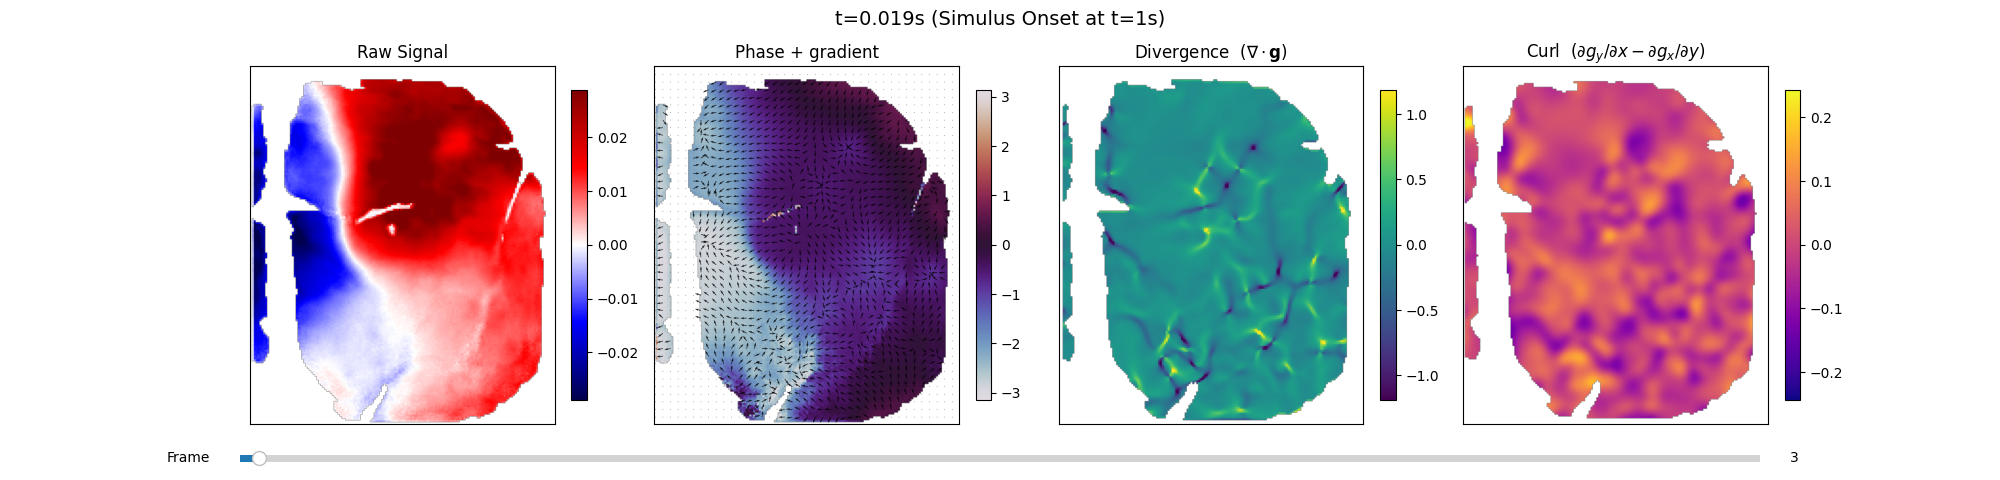

In [75]:
plt.close('all')
movie = trials['cfm002mjr/20240517/meas01/trial006']

results = analyze_phase(movie, fps, lo=1, hi=60, bandpass=False, sigma_px=1.0)
slider = plot_phase_results_slider(movie, results, plots=['raw_signal', 'gradient_vectors','divergence', 'curl'])

In [ ]:
for movie in trials.values():
    results = analyze_phase(movie, fps, lo=1, hi=60, bandpass=False, sigma_px=1.0)
    slider = plot_phase_results_slider(movie, results, plots=['raw_signal', 'amplitude', 'phase', 'gradient_vectors', 'divergence', 'curl'])

In [19]:
def play_and_save_numpy_movie(
    file_path, vmin=-0.04, vmax=0.04, fps=157/10, frame_start=None, frame_end=None, save=None, title=None
):
    """
    Load, play, and optionally save a numpy movie file.

    Parameters
    ----------
    file_path : str
        Path to the .npy file containing a 3D array (t, y, x).
    vmin, vmax : float or None
        Color limits for imshow. If None, inferred from data.
    fps : int
        Frames per second for playback.
    nframes : int or None
        Number of frames to show. If None, play the whole movie.
    save : {'mp4', 'gif', None}
        If given, save the movie in the same folder/filename as file_path,
        with the extension changed.
    """


    plt.rcParams['animation.ffmpeg_path'] = 'c:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/Lib/site-packages/imageio_ffmpeg/binaries/ffmpeg-win-x86_64-v7.1.exe'
    # Load movie
    movie = np.load(file_path)
    assert movie.ndim == 3, "Expected array of shape (t, y, x)"
    movie = movie[frame_start:frame_end]

    # Title = filename without path or extension
    if title == None:
        title = os.path.splitext(os.path.basename(file_path))[0]

    # ---------- Inline playback ----------
    interval = 1.0 / fps
    fig, ax = plt.subplots()
    for t in range(movie.shape[0]):
        ax.clear()
        im = ax.imshow(movie[t], vmin=vmin, vmax=vmax, cmap="seismic", origin="upper")
        ax.set_title(f"{title} (t={((t+1)/157):.2f} s)")
        ax.set_xticks([]); ax.set_yticks([])
        display(fig)
        clear_output(wait=True)
        time.sleep(interval)
    plt.close(fig)

    # ---------- Save to disk ----------
    if save is not None:
        out_path = os.path.splitext(file_path)[0] + f".{save}"
        fig, ax = plt.subplots()
        im = ax.imshow(movie[0], vmin=vmin, vmax=vmax, cmap="seismic", origin="upper")
        ax.set_title(title)
        ax.set_xticks([]); ax.set_yticks([])

        def update(frame):
            im.set_array(movie[frame])
            ax.set_title(f"{title}")
            return [im]

        ani = animation.FuncAnimation(fig, update, frames=range(movie.shape[0]), blit=True)
        if save == "mp4":
            ani.save(out_path, fps=fps, dpi=150)
        elif save == "gif":
            ani.save(out_path, writer="pillow", fps=fps)
        else:
            raise ValueError("save must be 'mp4', 'gif', or None")
        plt.close(fig)
        print(f"Saved to {out_path}")

In [37]:
play_and_save_numpy_movie('C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/wave_detection/wave_clips/cfm002mjr_20240517_meas01_trial091.npy', frame_start=int(1.2*157), frame_end=int(2.2*157),
                           title='cfm002mjr_20240517_meas01 (Spontaneous)', save='mp4')

Saved to C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/wave_detection/wave_clips/cfm002mjr_20240517_meas01_trial091.mp4


In [27]:
play_and_save_numpy_movie('C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/wave_detection/wave_clips/cfm002mjr_20240517_meas01_trial006.npy', save='mp4', nframes=140)

Saved to C:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/wave_detection/wave_clips/cfm002mjr_20240517_meas01_trial006.mp4


In [27]:
def _segments_from_nan_array(xy_nan):
    if xy_nan is None:
        return []
    arr = np.asarray(xy_nan)
    if arr.ndim != 2 or arr.shape[1] != 2:
        raise ValueError("contours must be a (M,2) array with NaN rows separating segments.")
    isn = np.any(np.isnan(arr), axis=1)
    splits = np.where(isn)[0]
    segs, start = [], 0
    for j in np.r_[splits, len(arr)]:
        seg = arr[start:j]
        if seg.size:
            segs.append(seg)
        start = j + 1
    return segs

def play_and_save_numpy_movie(
    trial_id,
    clips,                      # dict[trial_id -> np.ndarray (t,y,x)]
    vmin=-0.04, vmax=0.04,
    fps=157/10,
    frame_start=None, frame_end=None,
    save=None,                  # 'mp4' | 'gif' | None
    title=None,
    contours=None,              # NaN-separated (M,2) array in (x,y)
    stim_frames=None,           # dict: {trial_id: (on, off)} in frame indices
    slowdown=1.0,               # e.g., 2.0 plays/saves at half speed
):
    """
    Play a clip from `clips[trial_id]`, optionally overlay contours and stimulus indicator,
    and optionally save to disk. Filename is the full trial_id with '/' -> '_'.
    """
    plt.rcParams['animation.ffmpeg_path'] = 'c:/Users/Katie/Documents/Katie/Code/perception_project/perception_project/Lib/site-packages/imageio_ffmpeg/binaries/ffmpeg-win-x86_64-v7.1.exe'

    assert trial_id in clips, f"{trial_id!r} not found in clips"
    movie = np.asarray(clips[trial_id])
    assert movie.ndim == 3, "Movie must have shape (t, y, x)."
    movie = movie[frame_start:frame_end]
    T = movie.shape[0]

    if title is None:
        title = str(trial_id)

    # Contours -> list of segments
    segs = _segments_from_nan_array(contours)

    # Stimulus window for this trial (if provided)
    stim_window = None
    if isinstance(stim_frames, dict) and trial_id in stim_frames:
        stim_window = stim_frames[trial_id]
        on_f, off_f = stim_window

    # -------- Inline playback --------
    display_interval = slowdown / fps  # seconds between frames during display
    with plt.ioff():
        fig, ax = plt.subplots(figsize=(6.5, 5.0), constrained_layout=True)
    ax.set_xticks([]); ax.set_yticks([])

    im = ax.imshow(movie[0], vmin=vmin, vmax=vmax, cmap="seismic", origin="upper")
    ax.set_title(f"{title} (t={0.0:.3f} s)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046)

    # Contours overlay (static)
    if segs:
        lc = LineCollection(segs, colors='white', linewidths=1.3, alpha=0.9)
        lc.set_zorder(im.get_zorder() + 1)
        ax.add_collection(lc)

    # Stimulus indicator (axes coords)
    stim_rect = stim_text = None
    if stim_window is not None:
        margin, w, h = 0.02, 0.29, 0.05
        stim_rect = Rectangle((margin, 1.0 - margin - h), w, h,
                              transform=ax.transAxes, facecolor='limegreen',
                              edgecolor='black', linewidth=0.5, alpha=0.9,
                              zorder=im.get_zorder() + 2, visible=False, clip_on=False)
        ax.add_patch(stim_rect)
        stim_text = ax.text(margin + w/2, 1.0 - margin - h/2, "stimulus on",
                            transform=ax.transAxes, ha='center', va='center',
                            fontsize=10, color='white', weight='bold',
                            zorder=stim_rect.get_zorder() + 1, visible=False)

    for t in range(T):
        im.set_data(movie[t])
        ax.set_title(f"{title} (t={t/fps:.3f} s)")  # real movie time, not slowed time
        if stim_rect is not None:
            visible = (t >= on_f) and (t < off_f)
            stim_rect.set_visible(visible)
            stim_text.set_visible(visible)
        display(fig)
        clear_output(wait=True)
        time.sleep(display_interval)

    plt.close(fig)

    # -------- Save to disk --------
    if save is not None:
        assert save in {"mp4", "gif"}, "save must be 'mp4', 'gif', or None"
        # Full trial ID with '/' replaced by '_' (no directory components)
        base = str(trial_id).replace('/', '_')
        out_path = 'wave_clips/' + base + f".{save}"

        with plt.ioff():
            fig2, ax2 = plt.subplots(figsize=(6.5, 5.0), constrained_layout=True)
        ax2.set_xticks([]); ax2.set_yticks([])
        im2 = ax2.imshow(movie[0], vmin=vmin, vmax=vmax, cmap="seismic", origin="upper")
        ax2.set_title(title)
        cbar2 = fig2.colorbar(im2, ax=ax2, fraction=0.046)

        if segs:
            lc2 = LineCollection(segs, colors='white', linewidths=1.3, alpha=0.9)
            lc2.set_zorder(im2.get_zorder() + 1)
            ax2.add_collection(lc2)

        stim_rect2 = stim_text2 = None
        if stim_window is not None:
            margin, w, h = 0.02, 0.29, 0.05
            stim_rect2 = Rectangle((margin, 1.0 - margin - h), w, h,
                                   transform=ax2.transAxes, facecolor='limegreen',
                                   edgecolor='black', linewidth=0.5, alpha=0.9,
                                   zorder=im2.get_zorder() + 2, visible=False, clip_on=False)
            ax2.add_patch(stim_rect2)
            stim_text2 = ax2.text(margin + w/2, 1.0 - margin - h/2, "stimulus on",
                                  transform=ax2.transAxes, ha='center', va='center',
                                  fontsize=10, color='white', weight='bold',
                                  zorder=stim_rect2.get_zorder() + 1, visible=False)

        effective_fps = fps / slowdown  # slow the saved movie by the same factor

        def update(frame):
            im2.set_array(movie[frame])
            if stim_rect2 is not None:
                vis = (frame >= on_f) and (frame < off_f)
                stim_rect2.set_visible(vis)
                stim_text2.set_visible(vis)
            return [im2]  # outlines & cbar are static

        ani = animation.FuncAnimation(fig2, update, frames=range(T), blit=True)
        if save == "mp4":
            ani.save(out_path, fps=effective_fps, dpi=150)
        else:  # gif
            ani.save(out_path, writer="pillow", fps=effective_fps)

        plt.close(fig2)
        print(f"Saved to {out_path}")

In [71]:
play_and_save_numpy_movie(
    'cfm002mjr/20240517/meas01/trial022',
    trials,                      # dict[trial_id -> np.ndarray (t,y,x)]
    vmin=-0.03, vmax=0.03,
    fps=157,
    frame_start=None, frame_end=None,
    save='mp4',                  # 'mp4' | 'gif' | None
    title=None,
    contours=contours,              # NaN-separated (M,2) array in (x,y)
    stim_frames=stim_frames,           # dict: {trial_id: (on, off)} in frame indices
    slowdown=10.0,               # e.g., 2.0 plays/saves at half speed
)

Saved to wave_clips/cfm002mjr_20240517_meas01_trial022.mp4
